# Comparison between measures computed by WpmWithLdl and JudiLingMeasures

JudiLingMeasures is designed to closely adhere to the measures calculated by WpmWithLdl and LDLConvFunctions. The following notebook is designed to compare the measures calculated by them.

## Generate JudiLing measures

In [1]:
using JudiLing
using CSV # read csv files into dataframes
using DataFrames # parse data into dataframes
using Plots, StatsPlots # to look at some of the measures
using StatsBase
using JudiLingMeasures

Calculate the standard latin example, without training/validation split.

In [2]:
# if you haven't downloaded this file already, get it here:
# download("https://osf.io/2ejfu/download", "latin.csv")

latin =
    DataFrame(CSV.File(joinpath(@__DIR__, "latin.csv")));

cue_obj = JudiLing.make_cue_matrix(
    latin,
    grams = 3,
    target_col = :Word,
    tokenized = false,
    keep_sep = false
);

n_features = size(cue_obj.C, 2);
S = JudiLing.make_S_matrix(
    latin,
    ["Lexeme"],
    ["Person", "Number", "Tense", "Voice", "Mood"],
    ncol = n_features
);

G = JudiLing.make_transform_matrix(S, cue_obj.C);
F = JudiLing.make_transform_matrix(cue_obj.C, S);

Chat = S * G;
Shat = cue_obj.C * F;

A = cue_obj.A;
max_t = JudiLing.cal_max_timestep(latin, :Word);

res_learn, gpi_learn, rpi_learn = JudiLing.learn_paths_rpi(
    latin,
    latin,
    cue_obj.C,
    S,
    F,
    Chat,
    A,
    cue_obj.i2f,
    cue_obj.f2i, # api changed in 0.3.1
    gold_ind = cue_obj.gold_ind,
    Shat_val = Shat,
    check_gold_path = true,
    max_t = max_t,
    max_can = 10,
    grams = 3,
    threshold = 0.05,
    tokenized = false,
    sep_token = "_",
    keep_sep = false,
    target_col = :Word,
    issparse = :dense,
    verbose = false,
);

In [3]:
JudiLing.eval_SC(Shat, S)

0.9911

In [4]:
JudiLing.eval_acc(res_learn, cue_obj.gold_ind)

0.997

Compute all measures currently in JudiLingMeasures.

In [5]:
JLM_all_measures = JudiLingMeasures.compute_all_measures_train(latin, # the data of interest
                                                         cue_obj, # the cue_obj of the training data
                                                         Chat, # the Chat of the data of interest
                                                         S, # the S matrix of the data of interest
                                                         Shat, # the Shat matrix of the data of interest
                                                         F,
                                                         G,
                                                         res_learn_train=res_learn, # the output of learn_paths for the data of interest
                                                         gpi_learn_train=gpi_learn, # the gpi_learn object of the data of interest
                                                         rpi_learn_train=rpi_learn); # the rpi_learn object of the data of interest

Recognition not implemented


## Generate WpmWithLdl measures

In [6]:
using RCall

In [7]:
@rput latin;
@rput S; #make sure we are using the same S matrix in R

Make sure we are using the WpmWithLdl package version which is able to compute maximum number of measures :)

In [8]:
R"""
# install this only if you haven't yet :)
# install.packages("WpmWithLdl_1.3.17.1.tar.gz", repos = NULL, type="source")
library(WpmWithLdl)
""";

Calculate the standard latin example with WpmWithLdl.

In [9]:
R"""
cue_obj = make_cue_matrix(data=latin, formula=~Lexeme+Number+Person+Tense+Voice+Mood)

rownames(S) = rownames(cue_obj$matrices$C)

comp = learn_comprehension(cue_obj = cue_obj, S = S)
prod = learn_production(cue_obj = cue_obj, S = S)

comp_acc = accuracy_comprehension(m=comp, data=latin, show_rank=T, neighborhood_density=T)
prod_acc = accuracy_production(m=prod, data=latin, full_results=T, return_triphone_supports = TRUE)
""";

Compute measures in WpmWithLdl.

In [10]:
R"""
comp_measures = comprehension_measures(comp_acc, comp$Shat, S)
prod_measures = production_measures(prod_acc, S, prod)
""";

## Compare measures

First look at all measures calculated by JudiLingMeasures.

In [11]:
@rput JLM_all_measures
R"""
library(corrplot)
JLM_all_measures$Support = unlist(JLM_all_measures$Support)
JLM_all_measures$rank = unlist(JLM_all_measures$rank)
JLM_all_measures[,27] = unlist(JLM_all_measures[,27])
JLM_all_measures[,24] = unlist(JLM_all_measures[,24])
m = cor(JLM_all_measures[,c(9:37)], use="pairwise.complete.obs")
corrplot(m)
""";

┌ Warning: RCall.jl: Warnung: Paket ‘corrplot’ wurde unter R Version 4.0.2 erstellt
│ corrplot 0.84 loaded
└ @ RCall /Users/mariaheitmeier/.julia/packages/RCall/6kphM/src/io.jl:172


LoadError: REvalError: Fehler in cor(JLM_all_measures[, c(9:37)], use = "pairwise.complete.obs") : 
  'x' muss numerisch sein

Now the measures calculated by WpmWithLdl. First comprehension measures...

┌ Warning: RCall.jl: Warnung in cor(comp_measures) Standardabweichung ist Null
└ @ RCall /Users/mariaheitmeier/.julia/packages/RCall/6kphM/src/io.jl:172


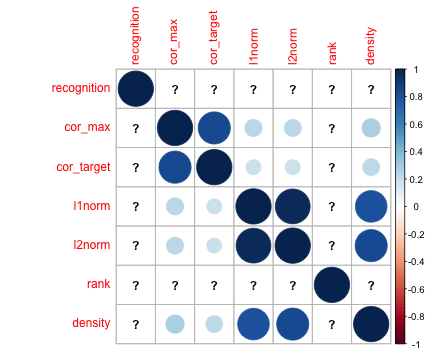

In [12]:
R"""
m1 = cor(comp_measures)
corrplot(m1)
""";

...then production measures.

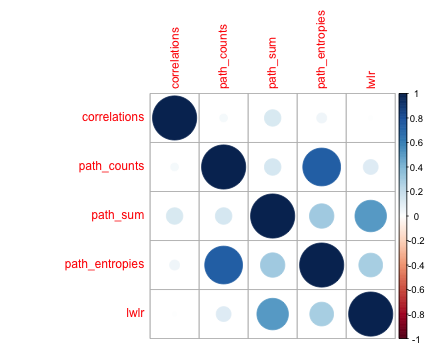

In [13]:
R"""
m2 = cor(prod_measures)
corrplot(m2)
""";

Now check correlation between Julia and R measures.

In [14]:
R"""
cat("Correlation between l1norm and L1Shat: ", cor(comp_measures$l1norm, JLM_all_measures$L1Shat, use="complete.obs"), "\n")
cat("Correlation between l2norm and L2Shat: ", cor(comp_measures$l1norm, JLM_all_measures$L2Shat, use="complete.obs"), "\n")
cat("Correlation between density and SemanticDensity: ", cor(comp_measures$density, JLM_all_measures$SemanticDensity, use="complete.obs"), "\n")
cat("Correlation between cor_max and NNC: ", cor(comp_measures$cor_max, JLM_all_measures$NNC, use="complete.obs"), "\n")
cat("Correlation between cor_target and TargetCorrelation: ", cor(comp_measures$cor_target, JLM_all_measures$TargetCorrelation, use="complete.obs"), "\n")
cat("Correlation between rank and rank: ", cor(comp_measures$rank, JLM_all_measures$rank, use="complete.obs"), "\n")
""";

Correlation between l1norm and L1Shat:  0.9999292 
Correlation between l2norm and L2Shat:  0.9683212 
Correlation between density and SemanticDensity:  0.9999762 
Correlation between cor_max and NNC:  0.9999409 
Correlation between cor_target and TargetCorrelation:  0.9999761 
Correlation between rank and rank:  NA 


┌ Warning: RCall.jl: Warnung in cor(comp_measures$rank, JLM_all_measures$rank, use = "complete.obs")
│   Standardabweichung ist Null
└ @ RCall /Users/mariaheitmeier/.julia/packages/RCall/6kphM/src/io.jl:172


The correlation between rank is NA, because the rank calculated by WpmWithLdl is always 1. However, it still looks pretty good:

In [15]:
R"""
table(comp_measures$rank, JLM_all_measures$rank)
"""

RObject{IntSxp}
   
      1   2   3
  1 666   2   4


The comprehension measures are very highly correlated. Let's look at the mean squared error between the two:

In [16]:
R"""
l2norm.fnc = function(x, y) return(sqrt(sum((x-y)^2)))

cat("Error between l1norm and L1Shat: ", l2norm.fnc(comp_measures$l1norm, JLM_all_measures$L1Shat), "\n")
cat("Error between l2norm and L2Shat: ", l2norm.fnc(comp_measures$l1norm, JLM_all_measures$L2Shat), "\n")
cat("Error between density and SemanticDensity: ", l2norm.fnc(comp_measures$density, JLM_all_measures$SemanticDensity), "\n")
cat("Error between cor_max and NNC: ", l2norm.fnc(comp_measures$cor_max, JLM_all_measures$NNC), "\n")
cat("Error between cor_target and TargetCorrelation: ", l2norm.fnc(comp_measures$cor_target, JLM_all_measures$TargetCorrelation), "\n")
cat("Error between rank and rank: ", l2norm.fnc(comp_measures$rank, JLM_all_measures$rank), "\n")
""";

Error between l1norm and L1Shat:  45.43261 
Error between l2norm and L2Shat:  51914.4 
Error between density and SemanticDensity:  0.001953033 
Error between cor_max and NNC:  0.001986079 
Error between cor_target and TargetCorrelation:  0.002297533 
Error between rank and rank:  4.242641 


High values are in L1Shat, but this is because those values are generally high:

In [17]:
R"""
mean(JLM_all_measures$L1Shat)
"""

RObject{RealSxp}
[1] 2168.252


Now look at the production measures. Note that all of the following measures are based on different algorithms, so precise correlation cannot be expected.

In [18]:
R"""
cat("Correlation between correlations and SCPP: ", cor(prod_measures$correlations, unlist(JLM_all_measures$SCPP), use="complete.obs"), "\n")
cat("Correlation between path_sum and PathSum: ", cor(prod_measures$path_sum, JLM_all_measures$PathSum, use="complete.obs"), "\n")
cat("Correlation between path_sum and PathSumChat: ", cor(prod_measures$path_sum, unlist(JLM_all_measures$PathSumChat), use="complete.obs"), "\n")
cat("Correlation between path_sum and PathSumChat: ", cor(prod_measures$path_sum, unlist(JLM_all_measures$PathSumChat), use="complete.obs"), "\n")
cat("Correlation between lwlr and lwlr: ", cor(prod_measures$lwlr, JLM_all_measures$lwlr, use="complete.obs"), "\n")
cat("Correlation between lwlr and lwlrChat: ", cor(prod_measures$lwlr, JLM_all_measures$lwlrChat, use="complete.obs"), "\n")
cat("Correlation between path_counts and PathCounts: ", cor(prod_measures$path_counts, JLM_all_measures$PathCounts, use="complete.obs"), "\n")
cat("Correlation between path_entropies and PathEntropiesChat: ", cor(prod_measures$path_entropies, unlist(JLM_all_measures$PathEntropiesChat), use="complete.obs"), "\n")
cat("Correlation between path_entropies and PathEntropiesChat where PathCounts is equal: ", cor(prod_measures$path_entropies[prod_measures$path_counts == JLM_all_measures$PathCounts], unlist(JLM_all_measures$PathEntropiesChat)[prod_measures$path_counts == JLM_all_measures$PathCounts], use="complete.obs"), "\n")
cat("Correlation between path_entropies and PathEntropiesSCP: ", cor(prod_measures$path_entropies, unlist(JLM_all_measures$PathEntropiesSCP), use="complete.obs"), "\n")
""";

Correlation between correlations and SCPP:  0.9604207 
Correlation between path_sum and PathSum:  0.8700151 
Correlation between path_sum and PathSumChat:  0.9993875 
Correlation between path_sum and PathSumChat:  0.9993875 
Correlation between lwlr and lwlr:  0.4580187 
Correlation between lwlr and lwlrChat:  0.726475 
Correlation between path_counts and PathCounts:  0.3064363 
Correlation between path_entropies and PathEntropiesChat:  0.4049213 
Correlation between path_entropies and PathEntropiesChat where PathCounts is equal:  0.999726 
Correlation between path_entropies and PathEntropiesSCP:  0.4089309 


Now also look at the errors. Where correlation is relatively low, they are pretty big.

In [19]:
R"""
cat("Error between correlations and SCPP: ", l2norm.fnc(prod_measures$correlations, unlist(JLM_all_measures$SCPP)), "\n")
cat("Error between path_sum and PathSum: ", l2norm.fnc(prod_measures$path_sum, JLM_all_measures$PathSum), "\n")
cat("Error between path_sum and PathSumChat: ", l2norm.fnc(prod_measures$path_sum, unlist(JLM_all_measures$PathSumChat)), "\n")
cat("Error between path_sum and PathSumChat: ", l2norm.fnc(prod_measures$path_sum, unlist(JLM_all_measures$PathSumChat)), "\n")
cat("Error between lwlr and lwlr: ", l2norm.fnc(prod_measures$lwlr, JLM_all_measures$lwlr), "\n")
cat("Error between lwlr and lwlrChat: ", l2norm.fnc(prod_measures$lwlr, JLM_all_measures$lwlrChat), "\n")
cat("Error between path_counts and PathCounts: ", l2norm.fnc(prod_measures$path_counts, JLM_all_measures$PathCounts), "\n")
cat("Error between path_entropies and PathEntropiesChat: ", l2norm.fnc(prod_measures$path_entropies, unlist(JLM_all_measures$PathEntropiesChat)), "\n")
cat("Error between path_entropies and PathEntropiesChat where PathCounts is equal: ", l2norm.fnc(prod_measures$path_entropies[prod_measures$path_counts == JLM_all_measures$PathCounts], unlist(JLM_all_measures$PathEntropiesChat)[prod_measures$path_counts == JLM_all_measures$PathCounts]), "\n")
cat("Error between path_entropies and PathEntropiesSCP: ", l2norm.fnc(prod_measures$path_entropies, unlist(JLM_all_measures$PathEntropiesSCP)), "\n")
""";

Error between correlations and SCPP:  0.09172048 
Error between path_sum and PathSum:  42.79015 
Error between path_sum and PathSumChat:  1.383245 
Error between path_sum and PathSumChat:  1.383245 
Error between lwlr and lwlr:  1289.752 
Error between lwlr and lwlrChat:  152.1508 
Error between path_counts and PathCounts:  399.02 
Error between path_entropies and PathEntropiesChat:  34.34175 
Error between path_entropies and PathEntropiesChat where PathCounts is equal:  0.1675789 
Error between path_entropies and PathEntropiesSCP:  34.2135 


Measures that are in JudiLingMeasures, but not in WpmWithLdl:
- ALC
- EDNN
- Support
- WithinPathEntropies
- ALDC
- MeanWordSupport
- C-Precision
- L1Chat
- SemanticSupportForForm

Measures that are in WpmWithLdl, but not in JudiLingMeasures:
- recognition

We can get a couple of additional measures from the LDLConvFunctions package:
- ALC
- EDNN
- ALDC
- NNC
- MeanWordSupport

So now we compute measures by the LDLConvFunctions package.

In [20]:
R"""
#devtools::install_github("dosc91/LDLConvFunctions", upgrade_dependencies = FALSE)
""";

LoadError: UndefVarError: val not defined

In [21]:
R"""
# load package
library(LDLConvFunctions)
library(FNN)
""";

┌ Warning: RCall.jl: Warnung: Paket ‘FNN’ wurde unter R Version 4.0.2 erstellt
└ @ RCall /Users/mariaheitmeier/.julia/packages/RCall/6kphM/src/io.jl:172


There is a small bug in MWS (I have reported this as an issue), which we fix here quickly.

In [22]:
# hotfix for a the mean word support function
R"""

MWS_hotfix <- function (prod_acc, prod_measures)
{
  MWSframe <- matrix(0, nrow = length(rownames(prod_measures)), ncol = 1)

  for (i in 1:length(rownames(prod_measures))) {
    MWSframe[i] <- prod_measures$path_sum[i] / length(prod_acc[["full"]][[i]]$li[which(prod_acc[["full"]][[i]]$values==max(prod_acc[["full"]][[i]]$values))[1]][[1]])


  }
  colnames(MWSframe) <- c("MWS")
  return(MWSframe)
}

""";

Now compute measures.

In [23]:
R"""
# I THINK that what is referred to as "Base" in LDLConvFunctions is the Lexeme in the latin data? I'm not entirely sure though.
latin$Base = latin$Lexeme

# compute measures
ALCframe <- ALC(pseudo_S_matrix = comp$Shat, real_S_matrix = S, pseudo_word_data = latin)
ALDCframe = ALDC(prod_acc = prod_acc, data = latin)
EDNNframe <- EDNN(comprehension = comp, data = latin)
NNCframe <- NNC(pseudo_S_matrix = comp$Shat, real_S_matrix = S,
                pseudo_word_data = latin, real_word_data = latin)
MWSframe =  MWS_hotfix(prod_acc, prod_measures) #here we use the hotfix
SCPPframe = SCPP(prod_measures, latin)

# put everything into one dataframe
LDLconv = cbind(ALCframe[,c(1,3)], ALDCframe[,c(1,3)], EDNNframe$EDNN, NNCframe$NNC, MWSframe, SCPPframe$SCPP)
colnames(LDLconv) = c("ALC", "Base", "Word", "ALDC", "EDNN", "NNC", "MWS", "SCPP")
for (c in c("ALC","ALDC", "EDNN", "NNC", "MWS", "SCPP")){
    LDLconv[,c] = as.numeric(unlist(LDLconv[,c]))
}
""";

Check out the measures.

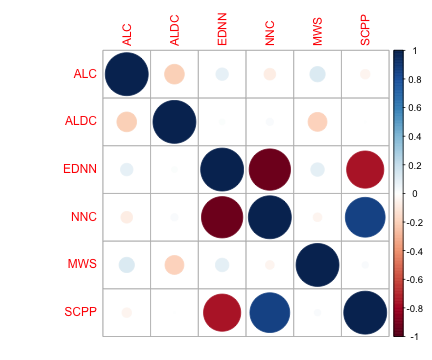

In [24]:
R"""
m3 = cor(LDLconv[,c("ALC", "ALDC", "EDNN", "NNC", "MWS", "SCPP")], use="complete.obs")
corrplot(m3)
""";

Compare LDLConvFunctions measures to JudiLingMeasures.

In [25]:
R"""
cat("Correlation between NNC and NNC: ", cor(LDLconv$NNC, JLM_all_measures$NNC, use="complete.obs"), "\n")
cat("Correlation between ALC and ALC: ", cor(LDLconv$ALC, JLM_all_measures$ALC, use="complete.obs"), "\n")
cat("Correlation between ALDC and ALDC: ", cor(LDLconv$ALDC, JLM_all_measures$ALDC, use="complete.obs"), "\n")
cat("Correlation between EDNN and EDNN: ", cor(LDLconv$EDNN, JLM_all_measures$EDNN, use="complete.obs"), "\n")
cat("Correlation between MWS and MeanWordSupport: ", cor(LDLconv$MWS, JLM_all_measures$MeanWordSupport, use="complete.obs"), "\n")
cat("Correlation between MWS and MeanWordSupportChat: ", cor(LDLconv$MWS, JLM_all_measures$MeanWordSupportChat, use="complete.obs"), "\n")
cat("Correlation between SCPP and SCPP: ", cor(LDLconv$SCPP, unlist(JLM_all_measures$SCPP), use="complete.obs"), "\n")
""";

Correlation between NNC and NNC:  0.9999409 
Correlation between ALC and ALC:  0.9999801 
Correlation between ALDC and ALDC:  0.3854877 
Correlation between EDNN and EDNN:  0.9995816 
Correlation between MWS and MeanWordSupport:  0.4889382 
Correlation between MWS and MeanWordSupportChat:  0.9818841 
Correlation between SCPP and SCPP:  0.9604207 


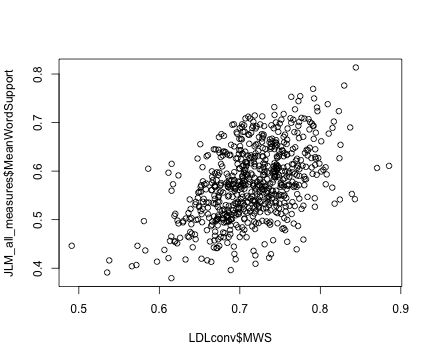

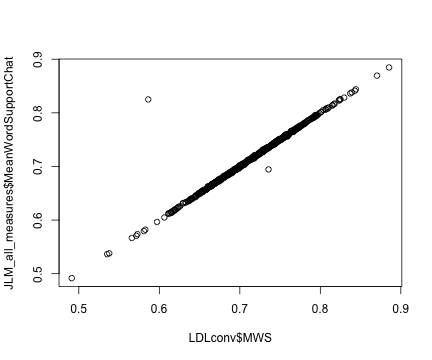

RObject{NilSxp}
NULL


In [26]:
R"""
plot(LDLconv$MWS, JLM_all_measures$MeanWordSupport)
plot(LDLconv$MWS, JLM_all_measures$MeanWordSupportChat)
"""

In [27]:
R"""
cat("Error between NNC and NNC: ", l2norm.fnc(LDLconv$NNC, JLM_all_measures$NNC), "\n")
cat("Error between ALC and ALC: ", l2norm.fnc(LDLconv$ALC, JLM_all_measures$ALC), "\n")
cat("Error between ALDC and ALDC: ", l2norm.fnc(LDLconv$ALDC, JLM_all_measures$ALDC), "\n")
cat("Error between EDNN and EDNN: ", l2norm.fnc(LDLconv$EDNN, JLM_all_measures$EDNN), "\n")
cat("Error between MWS and MeanWordSupport: ", l2norm.fnc(LDLconv$MWS, JLM_all_measures$MeanWordSupport), "\n")
cat("Error between MWS and MeanWordSupportChat: ", l2norm.fnc(LDLconv$MWS, JLM_all_measures$MeanWordSupportChat), "\n")
""";

Error between NNC and NNC:  0.001986079 
Error between ALC and ALC:  0.007051661 
Error between ALDC and ALDC:  39.65752 
Error between EDNN and EDNN:  6.105393 
Error between MWS and MeanWordSupport:  4.031195 
Error between MWS and MeanWordSupportChat:  0.2437135 


### pyldl

In [28]:
using PyCall
using Formatting

In [29]:
pyldl = pyimport("pyldl")
pm = pyimport("pyldl.mapping")
pandas = pyimport("pandas")
lmea = pyimport("pyldl.measures")
xarray = pyimport("xarray")

PyObject <module 'xarray' from '/Users/mariaheitmeier/miniconda3/envs/julia-python2/lib/python3.8/site-packages/xarray/__init__.py'>

Convert the matrices into the format used by pyldl.

In [30]:
cmat = xarray.DataArray(cue_obj.C, dims=("word", "cues"), 
                        coords = Dict("word"=>latin.Word, "cues"=>[cue_obj.i2f[i] for i in range(1,size(cue_obj.C,2))]));
chat = xarray.DataArray(Chat, dims=("word", "cues"), 
                        coords = Dict("word"=>latin.Word, "cues"=>[cue_obj.i2f[i] for i in range(1,size(cue_obj.C,2))]));
smat = xarray.DataArray(S, dims=("word", "semantics"), 
                        coords = Dict("word"=>latin.Word, "semantics"=>[string("S",fmt("03d", i)) for i in range(0,size(S,2)-1)]));
shat = xarray.DataArray(Shat, dims=("word", "semantics"), 
                        coords = Dict("word"=>latin.Word, "semantics"=>[string("S",fmt("03d", i)) for i in range(0,size(S,2)-1)]));
fmat = xarray.DataArray(F, dims=("cues", "semantics"), 
                        coords = Dict("cues"=>[cue_obj.i2f[i] for i in range(1,size(cue_obj.C,2))], "semantics"=>[string("S",fmt("03d", i)) for i in range(0,size(S,2)-1)]));

Compare comprehension and production uncertainty:

In [31]:
pyldl_comprehension_uncertainty = [lmea.uncertainty(word, chat, cmat) for word in latin.Word]
judilingmeasures_comp_uncertainty = JudiLingMeasures.uncertainty(cue_obj.C, Chat, method="cosine")
print(cor(pyldl_comprehension_uncertainty, judilingmeasures_comp_uncertainty))
println(sqrt(sum((pyldl_comprehension_uncertainty .- judilingmeasures_comp_uncertainty).^2)))

0.994033124207194517208.61159401736


In [32]:
pyldl_production_uncertainty = [lmea.uncertainty(word, shat, smat) for word in latin.Word]
judilingmeasures_prod_uncertainty = JudiLingMeasures.uncertainty(S, Shat, method="cosine")
println(cor(pyldl_production_uncertainty, judilingmeasures_prod_uncertainty))
println(sqrt(sum((pyldl_production_uncertainty .- judilingmeasures_prod_uncertainty).^2)))

0.9999999999999998
2.283584537469787e-9


Compare functional load:

In [33]:
pyldl_fl = [lmea.functional_load("#vo", fmat, word, smat, "corr") for word in latin.Word]
jlm_fl = JudiLingMeasures.functional_load(F,
                                               Shat,
                                               cue_obj,
                                               cue_list=repeat(["#vo"], size(latin,1)),
                                               method="corr")
println(cor(pyldl_fl, jlm_fl))
println(sqrt(sum((pyldl_fl .- jlm_fl).^2)))

0.9906549459591366
0.5411365532018944


In [34]:
pyldl_fl = [lmea.functional_load("#vo", fmat, word, smat, "mse") for word in latin.Word]
jlm_fl = JudiLingMeasures.functional_load(F,
                                               Shat,
                                               cue_obj,
                                               cue_list=repeat(["#vo"], size(latin,1)),
                                               method="mse")
println(cor(pyldl_fl, jlm_fl))
println(sqrt(sum((pyldl_fl .- jlm_fl).^2)))

0.9608076061719518
97.134137645229


They are both very well aligned!

## Summary

### Coverage
The following measures are in JudiLingMeasures, but not in either of the other packages:
- Support
- WithinPathEntropies
- C-Precision
- L1Chat
- SemanticSupportForForm

The following measures are in WpmWithLdl, but not in JudiLingMeasures:
- recognition

The following measures are in LDLConvFunctions, but not in JudiLingMeasures:
- DRC

### Measures accuracy
Generally, the comprehension based measures (not involving a production algorithm are very accurate). These are:
- NNC
- TargetCorrelation
- L1Norm
- L2Norm
- Density
- ALC
- EDNN

The production based measures are currently not very reliable, or at least they are currently different to the old measures. These are:
- PathCounts
- PathSum (though this is correlated .86, so probably not too bad)
- lwlr
- ALDC
- MeanWordSupport

However, as soon as the production-based measures are based on Chat instead of the Yhat matrices, they are very accurate again. These are:
- lwlrChat
- MeanWordSupportChat
- PathEntropiesChat
- PathSumChat

PathCounts and ALDC are based on the algorithm only and do not rely on Chat or Yhat, they are therefore still different. PathSumChat depends on PathCounts. If only word forms with the same PathCounts in WpmWithLDL and JudiLing are considered, PathSumChat is also very accurate.

There is one production measure which does not rely on a production algorithm and is therefore quite accurate again:
- SCPP